# Praktikum 1 - RNN untuk Analisis Sentimen

**Nama : Daffa Yudisa Akbar**

**Kelas : TI-3A / 06**

**NIM : 2241720008**

## Setup

Impor matplotlib dan buat fungsi pembantu untuk memplot grafik:

In [16]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [17]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## Setup input pipeline

Dataset ulasan film IMDB adalah kumpulan data klasifikasi biner—semua ulasan memiliki sentimen positif atau negatif.

Download dataset menggunakan TFDS. Lihat loading text tutorial jika ingin me load data secara manual

In [18]:
dataset, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Awalnya ini mengembalikan dataset (teks, pasangan label):

In [19]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


Berikutnya acak data untuk pelatihan dan membuat kumpulan pasangan (teks, label) ini:

In [20]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])


texts:  [b'"The College Girl Murders" is my first acquaintance with the writing work of Edgar Wallace \xc2\x96 and generally my first real acquaintance with "Krimi" films in general \xc2\x96 and I can say that I\'m moderately impressed. This stuff is really entertaining, although I never would have expected it to be so \xc2\x85 goofy! The film has an exhilarating and nicely convoluted plot, with a healthy dose of humor, flamboyant twists and pretty inventive killings. There\'s some James Bond type of evil mastermind \xc2\x96 who always sits in the shadow and in front of a large monitor - recruiting prisoners to kill certain girls at a specific college with a new type of poison. There\'s also a villainous monk with a whip, dressed like a communist KKK member, getting rid of the leftover characters, like overly curious teachers and such, as well as a kooky police commissioner who persists on solving the case with a psychological approach. Seriously, if I had known sooner that these Krimi

## Buat Teks Encoder

Teks mentah yang dimuat oleh tfds perlu diproses sebelum dapat digunakan dalam model. Cara termudah memproses teks untuk pelatihan adalah menggunakan lapisan TextVectorization. Lapisan ini memiliki banyak kemampuan, namun pada tutorial ini menggunakan perilaku default. Buat lapisan tersebut, dan teruskan teks kumpulan data ke metode .adapt lapisan:

In [21]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

Metode .adapt mengatur kosakata lapisan. 20 token pertama dapat dilihat dengan kode berikut. Setelah padding dan token yang tidak diketahui, mereka diurutkan berdasarkan frekuensi:

In [22]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Setelah kosakata diatur, lapisan dapat mengkodekan teks ke dalam indeks. Tensor indeks diberi bantalan 0 ke urutan terpanjang dalam batch (kecuali jika Anda menetapkan output_sequence_length tetap):

In [23]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[  2,   1, 247, ...,   0,   0,   0],
       [ 11, 777,   7, ...,   0,   0,   0],
       [ 10, 469, 138, ...,   0,   0,   0]])

Dengan pengaturan default, prosesnya tidak dapat dibalik sepenuhnya. Ada dua alasan utama untuk itu:

* Nilai default untuk argumen standarisasi preprocessing.TextVectorization adalah "lower_and_strip_punctuation".

* Ukuran kosa kata yang terbatas dan kurangnya fallback berbasis karakter menghasilkan beberapa token yang tidak diketahui.

In [24]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'"The College Girl Murders" is my first acquaintance with the writing work of Edgar Wallace \xc2\x96 and generally my first real acquaintance with "Krimi" films in general \xc2\x96 and I can say that I\'m moderately impressed. This stuff is really entertaining, although I never would have expected it to be so \xc2\x85 goofy! The film has an exhilarating and nicely convoluted plot, with a healthy dose of humor, flamboyant twists and pretty inventive killings. There\'s some James Bond type of evil mastermind \xc2\x96 who always sits in the shadow and in front of a large monitor - recruiting prisoners to kill certain girls at a specific college with a new type of poison. There\'s also a villainous monk with a whip, dressed like a communist KKK member, getting rid of the leftover characters, like overly curious teachers and such, as well as a kooky police commissioner who persists on solving the case with a psychological approach. Seriously, if I had known sooner that these Kri

## Buat Model

diagram model dapat dilihat pada gambar diatas

* Model ini dapat dibuat sebagai tf.keras.Sequential.

* Lapisan pertama adalah encoder, yang mengubah teks menjadi urutan indeks token.

* Setelah encoder adalah lapisan penyematan (embedding layer). Lapisan penyematan menyimpan satu vektor per kata. Saat dipanggil, ini mengubah rangkaian indeks kata menjadi rangkaian vektor. Vektor-vektor ini dapat dilatih. Setelah pelatihan (dengan data yang cukup), kata-kata dengan arti yang mirip sering kali memiliki vektor yang serupa. Pencarian indeks ini jauh lebih efisien daripada operasi setara dengan meneruskan vektor yang disandikan one-hot melalui lapisan tf.keras.layers.Dense.

* Jaringan saraf berulang (RNN) memproses masukan urutan dengan melakukan iterasi melalui elemen. RNN meneruskan keluaran dari satu langkah waktu ke masukannya pada langkah waktu berikutnya.

* Pembungkus tf.keras.layers.Bidirection juga dapat digunakan dengan lapisan RNN. Ini menyebarkan masukan maju dan mundur melalui lapisan RNN dan kemudian menggabungkan keluaran akhir.

* Keuntungan utama RNN dua arah adalah sinyal dari awal masukan tidak perlu diproses sepanjang waktu untuk memengaruhi keluaran.

* Kerugian utama dari RNN dua arah adalah Anda tidak dapat melakukan streaming prediksi secara efisien saat kata-kata ditambahkan di akhir.

* Setelah RNN mengonversi urutan menjadi satu vektor, kedua lapisan tersebut.Dense melakukan beberapa pemrosesan akhir, dan mengonversi representasi vektor ini menjadi logit tunggal sebagai keluaran klasifikasi.

Kode nya adalah sebagai berikut :

In [25]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

Harap dicatat bahwa model sekuensial Keras digunakan di sini karena semua lapisan dalam model hanya memiliki masukan tunggal dan menghasilkan keluaran tunggal. Jika Anda ingin menggunakan lapisan RNN stateful, Anda mungkin ingin membangun model Anda dengan API fungsional Keras atau subkelas model sehingga Anda dapat mengambil dan menggunakan kembali status lapisan RNN. Untuk detailnya bisa dilihat pada Keras RNN guide

Lapisan penyematan menggunakan masking (uses masking ) untuk menangani panjang urutan yang bervariasi. Semua lapisan setelah penyematan dukungan penyematan

In [26]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


Untuk memastikan bahwa ini berfungsi seperti yang diharapkan, evaluasi sebuah kalimat dua kali. Pertama, satu kalimat sehingga tidak ada bantalan (padding) untuk disamarkan:




In [45]:
# predict on a sample text without padding.

sample_text = ['The movie was cool. The animation and the graphics ',
               'were out of this world. I would recommend this movie.']

input_tensor = tf.convert_to_tensor(sample_text)
predictions = model.predict(input_tensor)
print(predictions[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step
[0.00369856]


Sekarang, evaluasi lagi dalam batch dengan kalimat yang lebih panjang. Hasilnya harus sama:

In [50]:
# predict on a sample text with padding

padding = "the " * 2000
text_with_padding = padding + ' '.join(sample_text)
input_tensor_with_padding = tf.convert_to_tensor([text_with_padding])
predictions = model.predict(input_tensor_with_padding)
print(predictions[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
[0.02223157]


compile model Keras untuk mengonfigurasi proses pelatihan:

In [51]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## Train Model

In [52]:
history = model.fit(train_dataset, epochs=10, validation_data=test_dataset, validation_steps=30)

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 737s 2s/step - accuracy: 0.5157 - loss: 0.6833 - val_accuracy: 0.7437 - val_loss: 0.5120
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 699s 2s/step - accuracy: 0.7581 - loss: 0.4818 - val_accuracy: 0.8188 - val_loss: 0.3692
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 717s 2s/step - accuracy: 0.8383 - loss: 0.3591 - val_accuracy: 0.8677 - val_loss: 0.3130
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 735s 2s/step - accuracy: 0.8498 - loss: 0.3347 - val_accuracy: 0.8536 - val_loss: 0.3338
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 741s 2s/step - accuracy: 0.8625 - loss: 0.3187 - val_accuracy: 0.8479 - val_loss: 0.3242
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 748s 2s/step - accuracy: 0.8682 - loss: 0.3074 - val_accuracy: 0.8526 - val_loss: 0.3593
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 708s 2s/step - accuracy: 0.8662 - loss: 0.3135 - val_accuracy: 0.8396 - val_loss: 0.3176
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 715s 2s/step - accuracy: 0.8652 - loss: 0.3065 - val_accu

In [53]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 ━━━━━━━━━━━━━━━━━━━━ 155s 397ms/step - accuracy: 0.8537 - loss: 0.3201
Test Loss: 0.32112523913383484
Test Accuracy: 0.8527600169181824


(0.0, 0.6682502999901772)

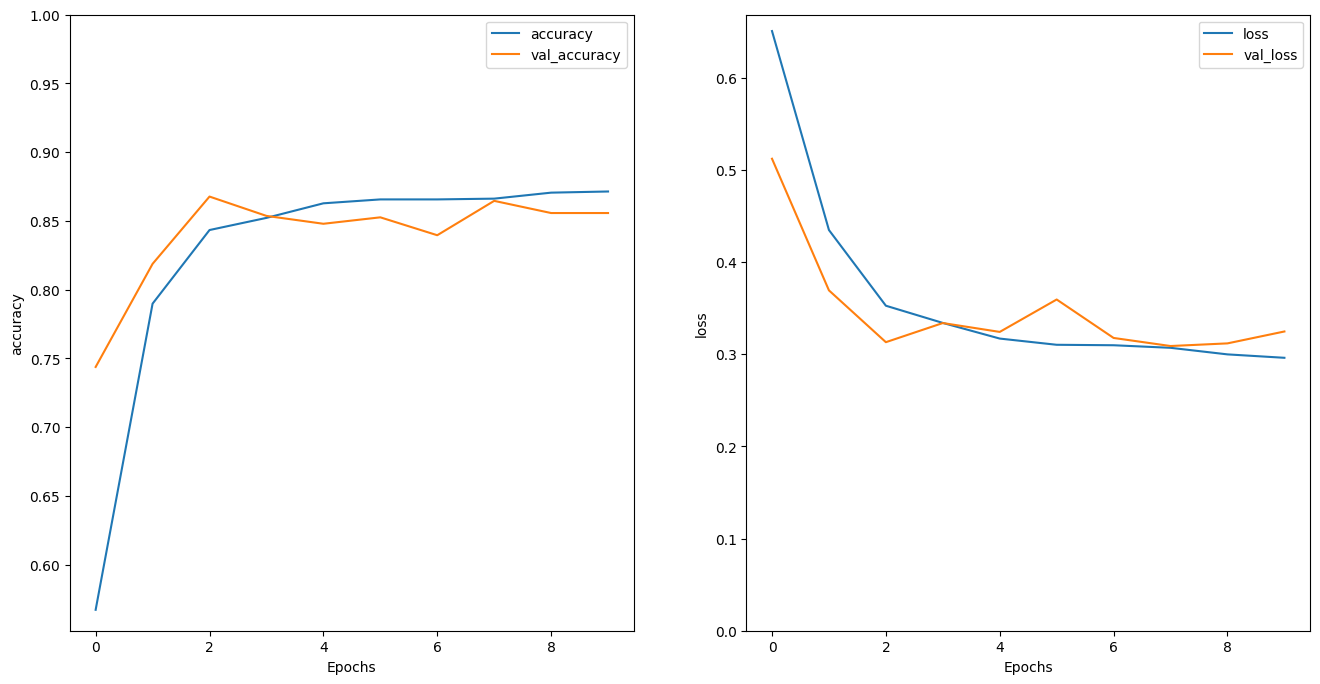

In [54]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Jalankan prediksi pada kalimat baru:

Jika prediksi >= 0,0 berarti positif, jika tidak maka negatif.

In [56]:
sample_text = ['The movie was cool. The animation and the graphics ',
               'were out of this world. I would recommend this movie.']

input_tensor = tf.convert_to_tensor(sample_text)
predictions = model.predict(input_tensor)
print(predictions[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
[0.81359345]
